# Introduction to digital forensics of cybercrime
## Assignment 3 - DDoS attack investigation
### Project Group 4
    Loek van der Gugten 1975331
    Reinier de Ridder   1701134
    Frank Nijeboer      2011972
    Jos Bartels         1941224
    Dionne Kingma       2419874
    Hanneke Verschoor   1954334

<h2 id="tocheading">Table of Contents</h2>
<div id="toc"></div>

## Introduction
&emsp; Type introduction here.

## Methodology
During the lecture, the lecturer (Jair Santana) recorded the traffic to his machine, by using [Wireshark](https://www.wireshark.org/). Wireshark is a network packet analyzer that is used by, among others, network administrators and network security engineers to analyze what happens on the network. Wireshark will present the packets that are captured in as much detail as possible. <cite data-cite="7233958/2QFFCFDH"></cite> 

The data that was captured during the lecture was saved in a '.pcapng' file ('for_the_afternoon.pcapng'), for use by the students. This file can be loaded in the Wireshark program to do analysis there, but there it is also possible to generate a '.csv' file based on the '.pcapng' file. CSV stands for 'Comma-separated values' and is a format to easily transfer data between different protocols. Some banks in the Netherlands, Rabobank for example, also used this format whenever their customers want to download their transaction data.<cite data-cite="7233958/R64I25J8"></cite> This was done for this Jupyter Notebook: columns were added to deliver more information for analysis and the .csv file was generated. This file is called 'for_the_afternoon.csv'. 

To analyze the data in this Jupyter Notebook, the [pandas](https://pandas.pydata.org/) python module is used. Pandas is an open source module that is widely used to perform data analysis in all kinds of fields of science. To visualize the data [matplotlib](https://matplotlib.org/) is used. Matplotlib is a python module capable of plotting 2D graphs based on data in the Dataframe objects from pandas. 

## Preprocessing the data
Before starting to analyze the data using pandas and matplotlib the data must be preprocessed to allow for easier plotting and analysis. This will be done in steps:

### Step 1: Generate a CSV file
Columns must be added to Wireshark to deliver more information in the '.csv' file that is used to generate a pandas Dataframe later on. The fields that will be added are: 
* 'Source Port': The port that was used by the sender of the packet. Wireshark field is 'Src port (resolved)'
* 'Destination Port': The port that received the packet. Wireshark field is 'Dest port (resolved)'
* 'Vendor': The Vendor of the device that send the packet. This vendor is based on the MAC Address that was used in the packet and automatically determined by Wireshark. Wireshark field is 'Hw src addr (resolved)'
* 'Source Mac Address': The MAC Address of the sender of a packet. Wireshark field is 'Hw src addr (unresolved)'
* 'TCP Flags': The flags that are used in the message. This is represented as a number starting with 0x. Wireshark field is 'tcp.flags'.
To add a column in Wireshark, simply click on an existing column and click 'Column Preferences' to add, remove and edit columns in Wireshark.

Now we can generate the '.csv' by clicking on ```File > Export Packet Dissections > As CSV...```. The '.csv' file is already included in this repository and will be used later on in this notebook.

### Step 2: Import Pandas and Matplotlib
Now that the '.csv' file is generated, python code can be written to import this data inside this notebook. The first step for that is to import the modules that will be used for the analysis.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

### Step 3:  Load the CSV inside a Dataframe
Data from the '.csv' file will be loaded in the variable 'df'.

In [2]:
df_file = "for_the_afternoon.csv"
df = pd.read_csv(df_file, index_col="No.")

### Step 4: Make the Flags Column Readable
The column 'TCP Flags' is not readable for humans when it is exported from Wireshark. Therefore a dictionary will be made that maps the code for a flag to a string representing the name of that TCP flag.

In [3]:
tcp_flags = {
    '0x002': 'SYN',
    '0x018': '(PSH, ACK)',
    '0x010': 'ACK',
    '0x012': '(SYN, ACK)',
    '0x014': '(RST, ACK)',
    '0x004': 'RST',
    '0x011': '(FIN, ACK)',
    '0x019': '(FIN, PSH, ACK)'
}
df['TCP Flags'] = df['TCP Flags'].apply(tcp_flags.get)

### Step 5: Remove the Numbers from the Vendor Column
The Vendor column, as it now is, shows the vendor of a device based on a Mac Address, followed by some string. Since there is no reaal need for this string after the vendor name, this will be removed from all entries in this column. 

In [4]:
df['Vendor'] = df['Vendor'].apply(lambda x: x.split("_")[0])

## Results
The preprocessing is done, meaning that calculating the results can start. Below, some paragraphs cana be foudn that analyze different paarts of the data.

### Entire Trace
First, some analysis will be done on the dataset as a whole, to determine how much traffic has been captured in this capture. Also, the duration of the entire capture can create some interesting insights that will show why this capture was unusual. 

#### Records
The first value that might be interesting is the amount of records in the capture file. This indicates the size of the attack. 
The amount of records is determined by getting the length of the Dataframe.

In [5]:
print("There are {} records in the entire trace.".format(len(df.index)))
df

There are 117333 records in the entire trace.


,Time,Source IP,Destination IP,Protocol,Length,Info,Source Port,Destination Port,Vendor,Source Mac Address,TCP Flags
No.,,,,,,,,,,,
1,0.000000,192.168.0.107,192.168.0.255,UDP,305,59199 > 54915 Len=263,59199.0,54915.0,IntelCor,a0:88:69:e0:2d:d3,None
2,0.102253,192.168.0.107,192.168.0.255,UDP,305,54915 > 54915 Len=263,54915.0,54915.0,IntelCor,a0:88:69:e0:2d:d3,None
3,0.244179,192.168.0.100,192.168.0.2,DNS,81,Standard query 0x4bf7 A p68-caldav.icloud.com,61098.0,53.0,Apple,8c:85:90:56:69:c0,None
4,0.305297,IntelCor_6c:2f:50,Broadcast,ARP,42,Who has 192.168.0.2? Tell 192.168.0.106,NaN,NaN,IntelCor,cc:3d:82:6c:2f:50,None
5,0.308302,192.168.0.2,192.168.0.100,ICMP,109,Destination unreachable (Port unreachable),61098.0,53.0,D-LinkIn,3c:1e:04:12:86:d8,None
...,...,...,...,...,...,...,...,...,...,...,...
117329,71.852720,192.168.0.100,192.168.0.121,TCP,66,"80 > 64484 [SYN, ACK] Seq=0 Ack=1 Win=65535 ...",80.0,64484.0,Apple,8c:85:90:56:69:c0,"(SYN, ACK)"
117330,71.852737,192.168.0.100,192.168.0.121,TCP,66,"80 > 64463 [SYN, ACK] Seq=0 Ack=1 Win=65535 ...",80.0,64463.0,Apple,8c:85:90:56:69:c0,"(SYN, ACK)"
117331,71.852776,192.168.0.100,192.168.0.121,TCP,66,"80 > 64464 [SYN, ACK] Seq=0 Ack=1 Win=65535 ...",80.0,64464.0,Apple,8c:85:90:56:69:c0,"(SYN, ACK)"


#### Duration
To identify the duration of the entire trace, the 'Time' column is used. The maximum value in this column identifies the duration of the trace. 

In [6]:
print("The duration of the trace is {} seconds.".format(df['Time'].max()))

The duration of the trace is 71.87289100000001 seconds.


Combining the duration and the amount of packets, the conclusion can be drawn that this is a case of unusual network traffic. There are 117333 packets send to and from a machine in a relative short timespan. This suggests that there is a possible DDoS attack going on on the system at the time of the capture.

#### When the attack started
What could help to determine the fingerprint of the attack is to determine when the DDoS attack started. For this, it is useful to study a graph that shows the amount of network traffic that was happening in this capture. This is done in pandas by first casting every all the 'Time' Columns to integers instead of doubles. After that, there is the option to group on this time value and sum up all the 'Length' columns for every time value. Now a graph can be made that will show the amount of MB/s at a given time. 

In the graph below a graph will be shown where the data rate will be plotted at each second in the capture.

**Note**: The graph that is made below is an interactive one. There is a slider that represents the upper limit of the x-axis of this graph. Changing this value and clicking on the 'Generate' button will generate a new graph with a new upper time limit. 

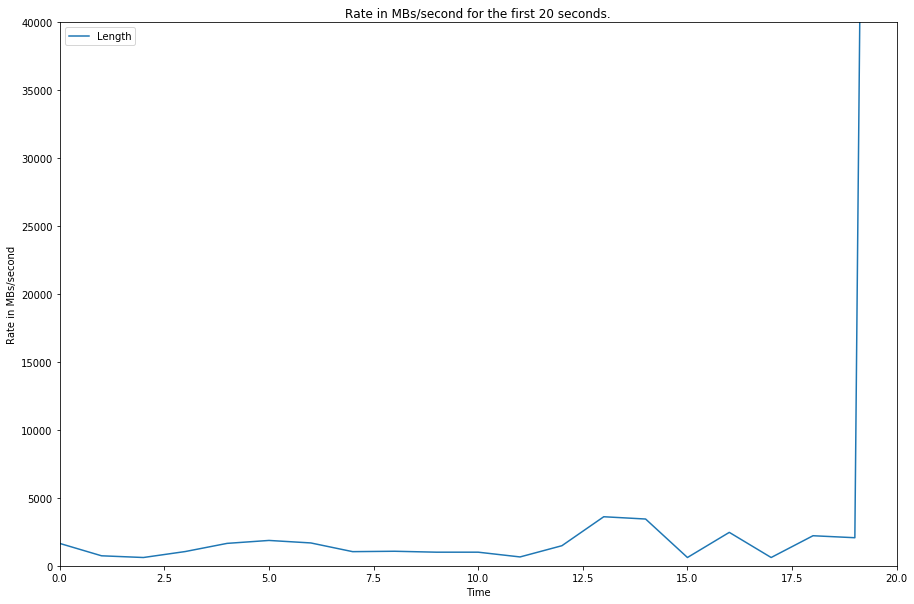

IntSlider(value=20, max=72, min=2)

Button(description='Generate', style=ButtonStyle())

In [7]:
import ipywidgets as widgets
from IPython.display import clear_output

class DataClass:
    def __init__(self):
        self.upper = 20
        
data_class = DataClass()    

slider = widgets.IntSlider(min=2, max=72, value=data_class.upper)
button = widgets.Button(description='Generate')

def graph(i=None):
    clear_output()
    entries = df
    entries['Time'] = entries['Time'].apply(int)
    entries = entries.loc[df['Time'] <= data_class.upper]
    entries.groupby(['Time']).sum().plot.line(y='Length', figsize=(15,10))
    plt.ylabel('Rate in MBs/second')
    plt.title('Rate in MBs/second for the first {} seconds.'.format(data_class.upper))
    plt.ylim(bottom=0, top=40000)
    plt.show()
    display(slider, button)
    
def change_value(i):
    data_class.upper = i['new']


slider.observe(change_value, names='value')
button.on_click(graph)
graph()

The data in the plot above shows a drastic increase in the data rate after 19 seconds. With the slider set to a value higher than 20, it is clear that this increase is massive. The rate does not fit on the y-axis anymore and stays there until the end of the capture. This gives a clear image at the timestamp of the attack.

### How many records are part of the attack?
Below the records that are part of the attack are listed. This Dataframe is filterd on packets where the destination IP is 192.168.0.100 (the target/victim) and the protocol is TCP. 

In [8]:
attack_entries = df.loc[df['Destination IP'] == "192.168.0.100"]
attack_entries = attack_entries.loc[attack_entries['Protocol'] == 'TCP']
print("There are {} records part of the attack.".format(len(attack_entries.index)))
attack_entries

There are 67177 records part of the attack.


,Time,Source IP,Destination IP,Protocol,Length,Info,Source Port,Destination Port,Vendor,Source Mac Address,TCP Flags
No.,,,,,,,,,,,
129,19,192.168.0.112,192.168.0.100,TCP,66,33600 > 80 [SYN] Seq=0 Win=64240 Len=0 MSS=1...,33600.0,80.0,IntelCor,ac:ed:5c:b9:d8:a9,SYN
131,19,192.168.0.112,192.168.0.100,TCP,54,33600 > 80 [ACK] Seq=1 Ack=1 Win=65536 Len=0,33600.0,80.0,IntelCor,ac:ed:5c:b9:d8:a9,ACK
133,19,192.168.0.112,192.168.0.100,TCP,80,"33600 > 80 [PSH, ACK] Seq=1 Ack=1 Win=65536 ...",33600.0,80.0,IntelCor,ac:ed:5c:b9:d8:a9,"(PSH, ACK)"
137,19,192.168.0.112,192.168.0.100,TCP,54,33600 > 80 [ACK] Seq=27 Ack=408 Win=65280 Len=0,33600.0,80.0,IntelCor,ac:ed:5c:b9:d8:a9,ACK
138,20,192.168.0.112,192.168.0.100,TCP,80,"33600 > 80 [PSH, ACK] Seq=27 Ack=408 Win=652...",33600.0,80.0,IntelCor,ac:ed:5c:b9:d8:a9,"(PSH, ACK)"
...,...,...,...,...,...,...,...,...,...,...,...
117314,71,192.168.0.121,192.168.0.100,TCP,66,64483 > 80 [SYN] Seq=0 Win=64240 Len=0 MSS=1...,64483.0,80.0,IntelCor,7c:5c:f8:89:d8:c5,SYN
117315,71,192.168.0.121,192.168.0.100,TCP,66,64462 > 80 [SYN] Seq=0 Win=64240 Len=0 MSS=1...,64462.0,80.0,IntelCor,7c:5c:f8:89:d8:c5,SYN
117316,71,192.168.0.121,192.168.0.100,TCP,66,64484 > 80 [SYN] Seq=0 Win=64240 Len=0 MSS=1...,64484.0,80.0,IntelCor,7c:5c:f8:89:d8:c5,SYN


The above code shows that there are 67177 packets in the attack, as it is filtered right now. As a reminder: the total amount of packets in the entire capture file is 117333. This means that there are still 117333 - 67177 = 50156 packets that are not part of the attack. These 'non-attack' packets could be the answers that the victim is able to send to the attackers. It might be useful to analyze what these 'non-attack' packets are and figure out the reason why there are so many of them. The below data shows a snippet of the data that was excluded by filters above and considered 'non-attack'.

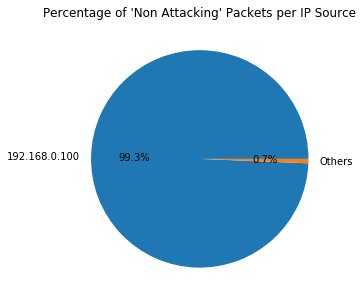

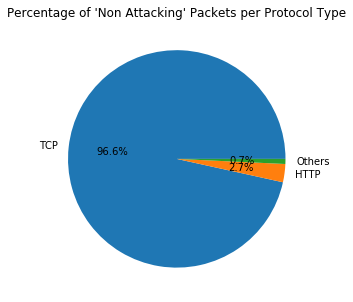

In [9]:
non_attackers = df.loc[df['Destination IP'] != "192.168.0.100"]
not_80 = non_attackers['Source IP'].value_counts().sort_values(ascending=False).index[1:]
non_attackers.replace(not_80, 'Others')['Source IP'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5,5))
plt.title("Percentage of 'Non Attacking' Packets per IP Source")
plt.ylabel("")
plt.show()

non_attackers = df.loc[df['Destination IP'] != "192.168.0.100"]
not_80 = non_attackers['Protocol'].value_counts().sort_values(ascending=False).index[2:]
non_attackers.replace(not_80, 'Others')['Protocol'].value_counts().plot.pie(autopct='%1.1f%%', figsize=(5,5))
plt.ylabel("")
plt.title("Percentage of 'Non Attacking' Packets per Protocol Type")
plt.show()

Most of the 'non-attacker' packets are send from 192.168.0.100, which is also the target for the attack. This means that the victim is also busy sending back packets to the attackers, overloading itself even more. And, as seen in the second pie chart, most of these 'non-attacker' packets have TCP as their protocol, strengthening the hypothesis that most of these 'non-attacker' packets are send by the victim itself. 

#### Three Packets that are not part of the attack
To take a deeper look at some regular packets in the attack, three packets will be extracted from the capture and analyzed deeper than above. The three packets that are extracted are all at the beginning of the capture file, before the attack started. 

In [10]:
df.iloc[1 : 4]

,Time,Source IP,Destination IP,Protocol,Length,Info,Source Port,Destination Port,Vendor,Source Mac Address,TCP Flags
No.,,,,,,,,,,,
2,0,192.168.0.107,192.168.0.255,UDP,305,54915 > 54915 Len=263,54915.0,54915.0,IntelCor,a0:88:69:e0:2d:d3,None
3,0,192.168.0.100,192.168.0.2,DNS,81,Standard query 0x4bf7 A p68-caldav.icloud.com,61098.0,53.0,Apple,8c:85:90:56:69:c0,None
4,0,IntelCor_6c:2f:50,Broadcast,ARP,42,Who has 192.168.0.2? Tell 192.168.0.106,NaN,NaN,IntelCor,cc:3d:82:6c:2f:50,None


The above packets are not a part of the attack. We can identify this packets as harmless because:
2. This packet is a regular UDP packet that is send to a different IP than the victim.
3. This packet is a DNS packet. DNS is the domain name service, so this packet can be explained as Jair’s machine contacting the DNS service to resolve some hostname. 
4. This packet is an ARP message. ARP stands for Address Resolution Protocol and it is used to discover, for example, which MAC Address belongs to a certain IP.<cite data-cite="7233958/QWC8AWJE"></cite> This can be seen in the 'Info' column of this packet.

### How many unique IPs are used in the attack?

In [11]:
uniques = attack_entries["Source IP"].nunique()
min_ip = attack_entries["Source IP"].min()
max_ip = attack_entries["Source IP"].max()
print("There are {} unique IP addresses. Ranging from {} to {}.".format(uniques, min_ip, max_ip))

There are 17 unique IP addresses. Ranging from 192.168.0.102 to 192.168.0.123.


###  Top 3 IP addresses in the attack

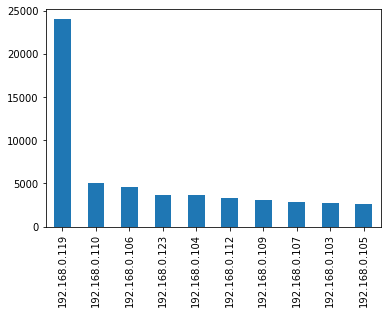

The top three consists of: 
	1) 192.168.0.119 
	2) 192.168.0.110 
	3) 192.168.0.106


In [12]:
top = attack_entries["Source IP"].value_counts().sort_values(ascending=False)
top.head(10).plot.bar()
plt.show()
print("The top three consists of: \n\t1) {p[0]} \n\t2) {p[1]} \n\t3) {p[2]}".format(p=top.head(3).index.tolist()))

### What is the distribution of vendors related to the source IP addresses involved in the attack? 

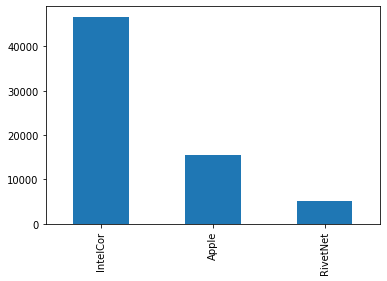

In [13]:
vendors = attack_entries['Vendor'].value_counts().sort_values(ascending=False)
vendors.plot.bar()
plt.show()

### Source Ports involved in the attack

In [14]:
min_source_port = attack_entries['Source Port'].min()
max_source_port = attack_entries['Source Port'].max()
print("The Source ports that are used in the attack are in the range between port {} and port {}.".format(int(min_source_port), int(max_source_port)))

The Source ports that are used in the attack are in the range between port 13501 and port 64827.


### TCP Flags involved
What is the distribution/frequency of TCP flags involved in the attack?


The Most TCP Flags were send by (PSH, ACK), namely 27339 packets.


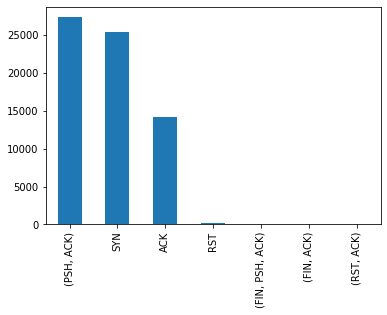

In [15]:
value_counts = attack_entries['TCP Flags'].value_counts()
print("The Most TCP Flags were send by {}, namely {} packets.".format(value_counts.idxmax(), value_counts.max()))
flags = value_counts
flags.plot.bar()
plt.show()

### How much was the data rate peak of the attack [Mbits/second]?

The data rate peak was after 28 seconds with 1450888.0 Mbits/second.


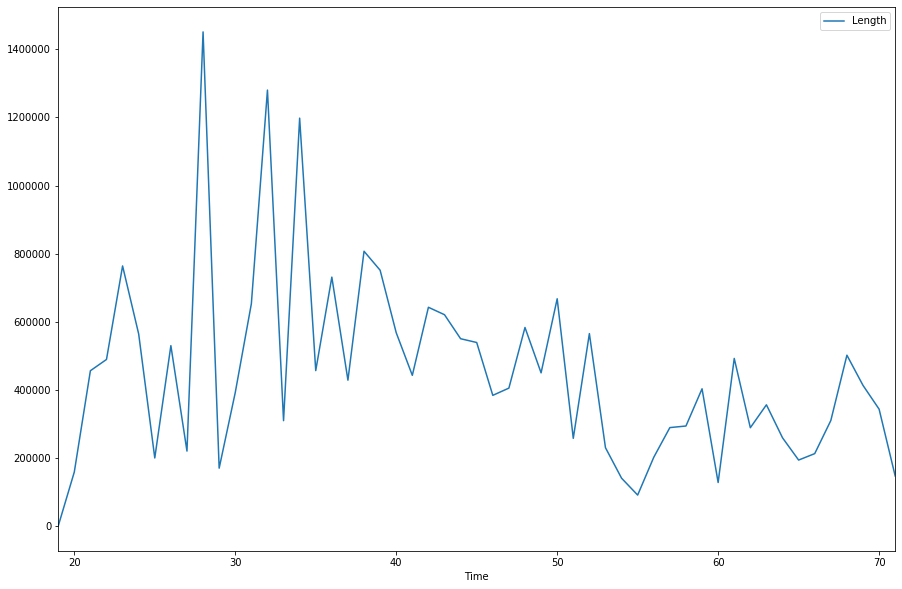

In [16]:
entries = attack_entries
entries['Time'] = entries['Time'].apply(int)
data_rate = entries.groupby(['Time']).sum()
data_rate.plot.line(y='Length', figsize=(15,10))
print("The data rate peak was after {} seconds with {} Mbits/second.".format(data_rate.idxmax()['Length'], data_rate.max()['Length']))
plt.ylabel('')
plt.show()

### What is the distribution/frequency of packet length ("total length")?

The Maximum category (<100) had 45404 packets in it.


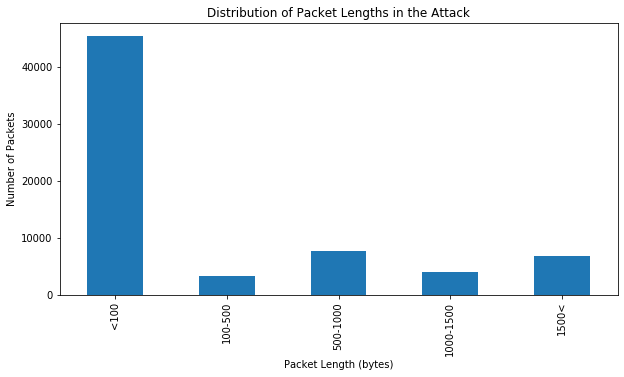

In [17]:
# attack_entries['Length'].value_counts().head(20).plot.bar(figsize=(20, 10))
ranges = [0, 100, 500, 1000, 1500, 20000]
categories = attack_entries.groupby(pd.cut(attack_entries['Length'], ranges, labels=['<100', '100-500', '500-1000', '1000-1500', '1500<'])).count()['Length']
print("The Maximum category ({}) had {} packets in it.".format(categories.idxmax(), categories.max()))
categories.plot.bar(figsize=(10, 5))
plt.xlabel('Packet Length (bytes)')
plt.ylabel('Number of Packets')
plt.title('Distribution of Packet Lengths in the Attack')
plt.show()

## References
<div class="cite2c-biblio"></div>

In [18]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>